In [18]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io, exposure
import matplotlib.pyplot as plt
import argparse
import numpy as np

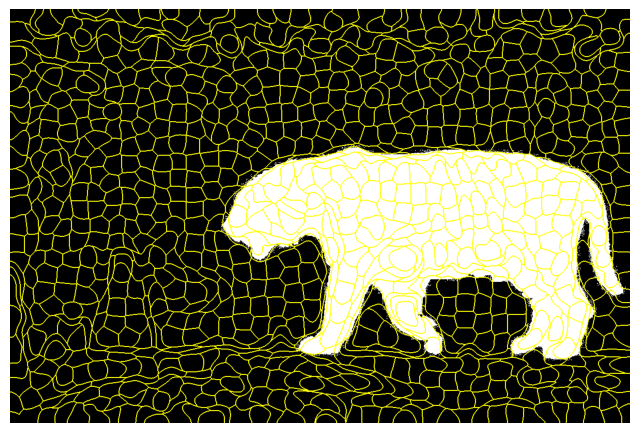

In [19]:
numSegments = 1000
image = img_as_float(io.imread('examples/tiger1.jpg'))
image_mask = (io.imread('examples/tiger1_mask.jpg') > 0)
# loop over the number of segments
# apply SLIC and extract (approximately) the supplied number
# of segments
segments = slic(image, n_segments = numSegments, sigma = 10)
# show the output of SLIC
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image_mask, segments))
plt.axis("off")
# show the plots
plt.show()

In [22]:
np.amin(segments)

1

In [21]:
def featureVector(img):
    v = []
    if(len(img.shape)==2):
        img = np.stack((img,img,img),axis = 2)
    for plane in range(img.shape[2]):
        h = exposure.histogram(img[:,:,plane])
        v = np.concatenate((v,h[0][1:]),axis=None)
   
    return v
    
    

In [23]:
numSegments = np.amax(segments)
features = []
labels = []
for s in range(1,numSegments):
    mask = (segments==s)
    if np.sum(mask)==0:
        break
    img = image * np.stack((mask,mask,mask), axis = 2)
    v = featureVector(img)
    overlap = (mask*image_mask)
    features.append(v)
    if np.sum(overlap)>=0.9*(np.sum(mask)):
        labels.append(1)
    else:
        labels.append(-1)

features = np.array(features)
labels = np.array(labels)

In [24]:
features.shape

(1000, 765)

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100,whiten=True)
features = pca.fit_transform(features)

In [27]:
from sklearn.svm import LinearSVC

model1 = LinearSVC()
model1.fit(features,labels)


/Users/banerji/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/banerji/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

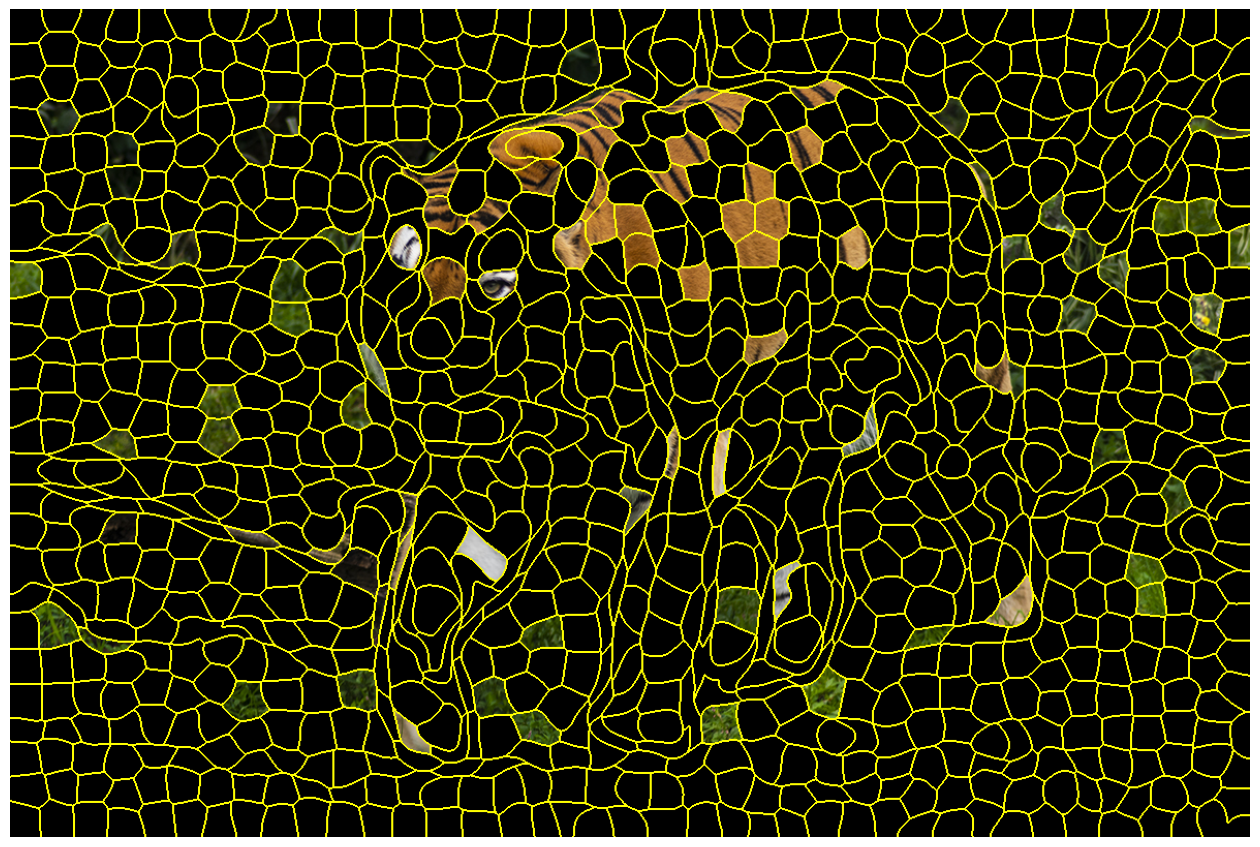

In [29]:
image = img_as_float(io.imread('examples/tiger.jpg'))
# image_mask = (io.imread('../data/tiger2_mask.jpg') > 0)
# apply SLIC and extract (approximately) the supplied number
# of segments
segments = slic(image, n_segments = numSegments, sigma = 10)
testFeatures = []
# show the output of SLIC
for s in range(1,numSegments):
    mask = (segments==s)
    if np.sum(mask)==0:
        break
    img = image * np.stack((mask,mask,mask), axis = 2)
    v = featureVector(img)
    testFeatures.append(v)

testFeatures = np.array(testFeatures)
testFeatures = pca.transform(testFeatures)
preds = model1.predict(testFeatures)

img = np.zeros(image.shape)
for s in range(testFeatures.shape[0]):
    mask = np.zeros((image.shape[0],image.shape[1]))
    if preds[s]>=0:
        mask = (segments==s)   
    img = img + image * np.stack((mask,mask,mask), axis = 2)    
        

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img, segments))
plt.axis("off")
# show the plots
plt.show()